In [1]:
import numpy as np
import pandas as pd
import subprocess as sp
import itertools as it
import sys, re, collections
import scipy as sc
import pgenlib as pg

In [2]:
%matplotlib inline
import matplotlib
matplotlib.use('agg')
from matplotlib import pyplot as plt

/home/ytanigaw/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
def make_hist(x, title = None, xlabel = None, ylabel = None, filename = None):
    '''
    This function generates histogram of a vector x and save to file
    Inputs:
      x: data vector
      title:    title of the plot
      xlabel:   label on x-axis
      ylabel:   label on y-axis
      filename: name of the image file (if given, save to file)
    Returns:
      matlab plot object
    Side effect:
      save an image file if filename is given
    '''
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(x, 20)
    
    if(xlabel != None):
        ax.set_xlabel(xlabel)
    if(ylabel != None):
        ax.set_ylabel(ylabel)
    if(title != None):
        ax.set_title(title)
    if(filename != None):
        fig.savefig(filename)

# prepare params & files

In [5]:
chromosome = '20'

In [6]:
# specify population pgen file data set here
#file_head = '/share/PI/mrivas/data/1000genomes/ALL.chr{}.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes-pgen'.format(chromosome)
file_head = '/share/PI/mrivas/ukbb/download/chr{}impv1-pgen'.format(chromosome)

In [7]:
pgen = {}
bim  = {}
genome_index_to_variant_index = {}
bim_col_names = ['chr', 'id', 'morgan', 'bp', 'pri', 'sec']

### population reference data

In [8]:
pgen[chromosome] = pg.PgenReader('{}.pgen'.format(file_head))
bim[chromosome]  = pd.read_csv('{}.bim'.format(file_head),
                               sep = '\t', names = bim_col_names)
genome_index_to_variant_index[chromosome] = \
dict(zip(bim[chromosome]['bp'], range(len(bim[chromosome]))))

In [9]:
# number of samples in the population
sample_ct = pgen[chromosome].get_raw_sample_ct()

In [10]:
print 'This data set has {} samples'.format(sample_ct)

This data set has 152249 samples


### our observation

In [11]:
snps_f =  '/share/PI/mrivas/data/nanopore-wgs-consortium-old/nanopore-wgs.25000.sorted.10k.mapq50.ext.sorted.informative.q14.snps'
reads = pd.read_csv(snps_f, sep = '\t')

In [12]:
def parse_snps_str(snps_str, filter_by_dbsnp = True):
    list_of_snps = [re.split(',|:',snp) for snp in snps_str.split(';')]
    if(filter_by_dbsnp):
        '''
        keep only snps with valid snp id
        '''
        list_of_snps = np.array([snp for snp in list_of_snps
                                 if snp[4][:2] == 'rs'])
    return(list_of_snps)

In [13]:
# reconstruct list of snps
reads['snps'] = np.array([parse_snps_str(reads.ix[read_num, 6]) 
                          for read_num in range(len(reads))])

In [14]:
# add field of chromosome number
reads['chr'] = np.array([reads['snps'][read_num][0][0][3:]
                         for read_num in range(len(reads))])

In [15]:
# extracting snp positions
reads['snp_pos'] = np.array([[int(x) for x in reads.ix[read_num, 'snps'][:, 1]]
                             for read_num in range(len(reads))])

In [16]:
def snp_poss_to_variant_idxs(snp_poss, conv_dict):
    return(np.array([conv_dict[snp_pos] for snp_pos 
                     in snp_poss if snp_pos in conv_dict],
                   dtype = np.uint32))

In [17]:
# want to see if my code correctly extracts SNP positions
read_num = 334
snp_poss_to_variant_idxs(reads['snp_pos'][read_num], 
                         genome_index_to_variant_index[reads['chr'][read_num]])

array([18585, 18687, 18757, 18935, 18967, 19046, 19050, 19089, 19159,
       19223, 19418, 19421, 19442, 19485, 19508], dtype=uint32)

In [18]:
# take subset of fragments on the chromosome of interest
reads_chr20 = reads[reads['chr'] == '20']
print reads_chr20.shape

(13, 10)


In [19]:
reads_chr20.head(3)

,name,#mismatches,#mismatches_with_hits_to_dbSNP,#SNPs_with_var_id,#SNPs_with_var_id(validated),length,"snps([<pos>,<ref>,<seq>,<varid>,<validated>,<baseCallQ>;]+)",snps,chr,snp_pos
334,1f3ad947-2a90-4c4c-8155-c8ca34c3a4d9_Basecall_...,47,17,16,14,32044,"chr20:712806,T,A,*,None,16;chr20:712968,C,G,*,...","[[chr20, 714008, a, G, rs2317021, True, 18], [...",20,"[714008, 717649, 720916, 727476, 728499, 73089..."
335,5ac37613-6f90-4320-9c8e-fefb98f49f25_Basecall_...,35,14,13,12,29431,"chr20:1341776,a,G,*,None,14;chr20:1342191,c,T,...","[[chr20, 1344929, C, A, rs6033551, True, 18], ...",20,"[1344929, 1345368, 1346236, 1346381, 1347754, ..."
336,021d57af-e9b8-49d6-b200-7793894f18a2_Basecall_...,40,16,15,14,27679,"chr20:4376042,A,G,*,None,17;chr20:4376044,C,A,...","[[chr20, 4379857, c, A, rs3848822, True, 17], ...",20,"[4379857, 4381876, 4382054, 4385424, 4385756, ..."


In [20]:
reads_chr20.ix[:, 'snps']

334    [[chr20, 714008, a, G, rs2317021, True, 18], [...
335    [[chr20, 1344929, C, A, rs6033551, True, 18], ...
336    [[chr20, 4379857, c, A, rs3848822, True, 17], ...
337    [[chr20, 15106978, c, T, rs975993, True, 15], ...
338    [[chr20, 16114674, g, A, rs971314, True, 16], ...
339    [[chr20, 17213181, c, G, rs8116844, True, 14],...
340    [[chr20, 35005210, c, T, rs538777470, False, 1...
341    [[chr20, 43923028, a, G, rs66503531, True, 15]...
342    [[chr20, 47824040, t, A, rs6095462, True, 16],...
343    [[chr20, 48302652, C, T, rs1016234, True, 14],...
344    [[chr20, 51259768, T, C, rs856409, True, 17], ...
345    [[chr20, 53759041, a, G, rs6069139, True, 19],...
346    [[chr20, 54342375, T, C, rs13041144, True, 14]...
Name: snps, dtype: object

In [21]:
# convert SNP position (genome coordinate) to variant index (on bim file)
genome_index_to_variant_index['20'][714008]

18585

In [22]:
variant_idxs = \
np.array([snp_poss_to_variant_idxs(reads_chr20['snp_pos'][read_num], 
                                   genome_index_to_variant_index[reads['chr'][read_num]])
          for read_num in range(334, 347)])

In [23]:
variant_idxs[0]

array([18585, 18687, 18757, 18935, 18967, 19046, 19050, 19089, 19159,
       19223, 19418, 19421, 19442, 19485, 19508], dtype=uint32)

In [24]:
def read_haplotype(pgen, variant_idxs):
    '''
    Wrapper function to read haplotype with pgenlib
    '''
    sample_ct = pgen.get_raw_sample_ct()
    read_alleles_list_buf = np.zeros((len(variant_idxs), 
                                      2 * sample_ct), 
                                     dtype=np.int32)
    # query pgen file and obtain allels
    pgen.read_alleles_list(variant_idxs, read_alleles_list_buf)

    # convert to string representation of haplotype
    hap_strs = [''.join([str(bit) for bit 
                             in read_alleles_list_buf[:, hap]])
                for hap in range(2 * sample_ct)]

    # convert each haplotype to an interger number
    #  assuming that len(variant_idxs)
    if(len(variant_idxs) <= 63):
        haps = np.array([int(hap_str, 2) for hap_str in hap_strs])
    else:
        haps = np.array([long(hap_str, 2) for hap_str in hap_strs])

    return(haps)

In [26]:
def read_haplotype_debug(pgen, variant_idxs):
    '''
    Wrapper function to read haplotype with pgenlib
    '''
    sample_ct = pgen.get_raw_sample_ct()
    read_alleles_list_buf = np.zeros((len(variant_idxs), 
                                      2 * sample_ct), 
                                     dtype=np.int32)
    # query pgen file and obtain allels
    pgen.read_alleles_list(variant_idxs, read_alleles_list_buf)

    return(read_alleles_list_buf)

In [27]:
read_alleles_list_buf = read_haplotype_debug(pgen[chromosome], variant_idxs[0])

In [29]:
read_alleles_list_buf.shape

(15, 304498)

In [30]:
len(variant_idxs[0])

15

In [31]:
hap_strs = [''.join([str(bit) for bit 
                             in read_alleles_list_buf[:, hap]])
                for hap in range(2 * sample_ct)]

In [32]:
len(hap_strs)

304498

In [33]:
hap_strs[0]

'011000000000001'

In [35]:
int(hap_strs[0], 2)

12289

In [44]:
haps = np.array([int(hap_str, 2) for hap_str in hap_strs[:13]])

ValueError: invalid literal for int() with base 2: '00-9000000-900000'

In [45]:
hap_strs[13]

'01-9111111-901001'

In [51]:
read_alleles_list_buf.shape

(15, 304498)

In [52]:
sample_ct * 2

304498

In [57]:
read_alleles_list_buf_filtered = np.array([read_alleles_list_buf[:, i] 
                                  for i in range(sample_ct * 2)
                                  if -9 not in read_alleles_list_buf[:, i]])

In [59]:
read_alleles_list_buf_filtered.shape

(264612, 15)

In [62]:
hap_strs = [''.join([str(bit) for bit 
                     in read_alleles_list_buf[:, hap]])
            for hap in range(2 * sample_ct)
            if -9 not in read_alleles_list_buf[:, i]]

In [64]:
hap_strs[:10]

['011000000000001',
 '011111111101011',
 '111111111100000',
 '111111111100001',
 '111101111001001',
 '111111111101001',
 '010000001000011',
 '010000001011111',
 '011101111001001',
 '111101111001001']

In [65]:
haps = np.array([int(hap_str, 2) for hap_str in hap_strs if '9' not in hap_str])

In [66]:
def read_haplotype_dev(pgen, variant_idxs):
    '''
    Wrapper function to read haplotype with pgenlib
    '''
    sample_ct = pgen.get_raw_sample_ct()
    read_alleles_list_buf = np.zeros((len(variant_idxs), 
                                      2 * sample_ct), 
                                     dtype=np.int32)
    # query pgen file and obtain allels
    pgen.read_alleles_list(variant_idxs, read_alleles_list_buf)

    # convert to string representation of haplotype
    hap_strs = [''.join([str(bit) for bit 
                             in read_alleles_list_buf[:, hap]])
                for hap in range(2 * sample_ct)]

    # convert each haplotype to an interger number
    #  assuming that len(variant_idxs)
    if(len(variant_idxs) <= 63):
        haps = np.array([int(hap_str, 2) for hap_str in hap_strs if '9' not in hap_str])
    else:
        haps = np.array([long(hap_str, 2) for hap_str in hap_strs if '9' not in hap_str])

    return(haps)

## turns out that the issue is caused by missimg values

In [48]:
print (-9 in read_alleles_list_buf[:, 0])
print (-9 in read_alleles_list_buf[:, 13])

False
True


In [25]:
haps = read_haplotype(pgen[chromosome], variant_idxs[0])

ValueError: invalid literal for int() with base 2: '00-9000000-900000'

In [67]:
haps = read_haplotype_dev(pgen[chromosome], variant_idxs[0])

In [68]:
haps.shape

(264612,)

In [69]:
haps

array([12289, 16363, 32736, ..., 16351, 32765, 32765])

## number of haplotypes in this region

In [70]:
# count frequency of haplotypes for maximum likelihood estiamte
haps_cnt = collections.Counter(haps)

In [73]:
print 'there are {} haplotypes in this region'.format(len(set(haps_cnt.keys())))

there are 564 haplotypes in this region


In [78]:
# we can get frequency count of a given haplotype in the population
for hap in [0, 20470]:
    print hap, haps_cnt[hap]

0 14506
20470 0


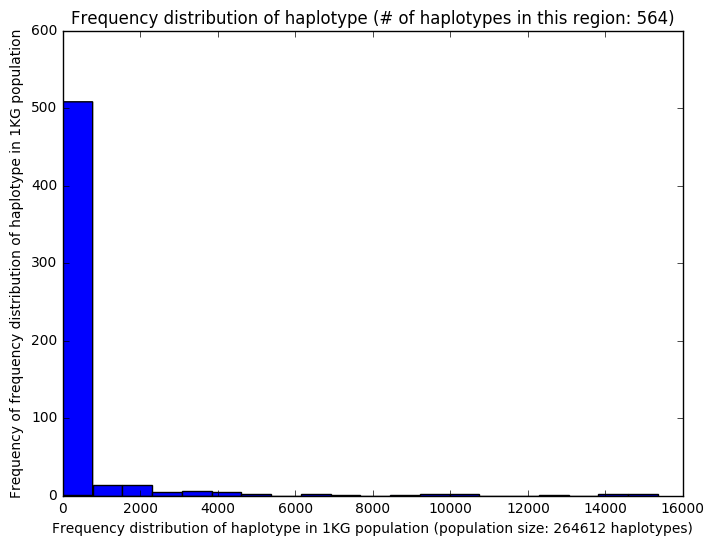

In [79]:
make_hist(1.0 * np.array(haps_cnt.values()),
          title='Frequency distribution of haplotype (# of haplotypes in this region: {})'.format(len(set(haps_cnt.keys()))),
          xlabel = 'Frequency distribution of haplotype in 1KG population (population size: {} haplotypes)'.format(haps.shape[0]),
          ylabel = 'Frequency of frequency distribution of haplotype in 1KG population',
          filename = None)

## snps to haplotype
- our observation is SNPs relative to reference genome
- want to convert bit string (0 means primary on population, 1 means secondary on population)

### our observation is represented as sequence of snps

In [103]:
# want to know which column is what
reads_chr20.columns

Index([u'name', u'#mismatches', u'#mismatches_with_hits_to_dbSNP',
       u'#SNPs_with_var_id', u'#SNPs_with_var_id(validated)', u'length',
       u'snps([<pos>,<ref>,<seq>,<varid>,<validated>,<baseCallQ>;]+)', u'snps',
       u'chr', u'snp_pos'],
      dtype='object')

### take a sample read

In [104]:
bim334 = bim[chromosome].ix[variant_idxs[0], :]
snp334 = reads_chr20.ix[334, 'snps']
snp334_filtered = np.array([snp for snp in snp334 if int(snp[1]) in set(bim334['bp'])])
snp334_filtered

array([['chr20', '714008', 'a', 'G', 'rs2317021', 'True', '18'],
       ['chr20', '717649', 'c', 'T', 'rs6117373', 'True', '16'],
       ['chr20', '720916', 'G', 'A', 'rs2144930', 'True', '14'],
       ['chr20', '727476', 'c', 'T', 'rs60461885', 'True', '16'],
       ['chr20', '728499', 'a', 'C', 'rs6054508', 'True', '16'],
       ['chr20', '730893', 'c', 'T', 'rs57596504', 'True', '16'],
       ['chr20', '731005', 'a', 'G', 'rs13039346', 'True', '19'],
       ['chr20', '732295', 'a', 'G', 'rs6140092', 'True', '19'],
       ['chr20', '734617', 'a', 'G', 'rs56210940', 'True', '16'],
       ['chr20', '736644', 'g', 'A', 'rs6140099', 'True', '16'],
       ['chr20', '743018', 'G', 'T', 'rs6038642', 'True', '18'],
       ['chr20', '743124', 'C', 'G', 'rs13039544', 'True', '14'],
       ['chr20', '743827', 'g', 'A', 'rs910858', 'True', '16'],
       ['chr20', '745181', 'A', 'T', 'rs6077095', 'False', '18'],
       ['chr20', '746098', 'G', 'A', 'rs3746808', 'True', '16']], 
      dtype='|S11'

- 3rd column: reference (a, c, G, c)
- 4th column: read (G, T, A, T)

## corresponding populatoin reference is as follows:

In [105]:
bim334

,chr,id,morgan,bp,pri,sec
18585,20,rs2317021,0,714008,A,G
18687,20,rs6117373,0,717649,C,T
18757,20,rs2144930,0,720916,G,A
18935,20,rs60461885,0,727476,C,T
18967,20,rs6054508,0,728499,A,C
19046,20,rs57596504,0,730893,C,T
19050,20,rs13039346,0,731005,A,G
19089,20,rs6140092,0,732295,A,G
19159,20,rs56210940,0,734617,A,G
19223,20,rs6140099,0,736644,G,A


In [106]:
def construct_haplotype_from_snp_sub(snps, pri, sec):

    print 'obs: ', snps
    print 'pri: ', pri
    print 'sec: ', sec
    hap = np.array(['0' if snps[i] == pri[i]
                    else '1' if snps[i] == sec[i]
                    else '2'
                    for i in range(len(snps))])
    if '2' in hap:
        raise Exception('oops')
    if(len(hap) <= 63):
        return(int(''.join(hap), 2))
    else:
        return(long(''.join(hap), 2))

In [107]:
hap_334 = \
construct_haplotype_from_snp_sub(snp334_filtered[:, 3].tolist(),
                                 bim334['pri'].tolist(),
                                 bim334['sec'].tolist())
print bin(hap_334)

obs:  ['G', 'T', 'A', 'T', 'C', 'T', 'G', 'G', 'G', 'A', 'T', 'G', 'A', 'T', 'A']
pri:  ['A', 'C', 'G', 'C', 'A', 'C', 'A', 'A', 'A', 'G', 'G', 'C', 'G', 'A', 'G']
sec:  ['G', 'T', 'A', 'T', 'C', 'T', 'G', 'G', 'G', 'A', 'T', 'G', 'A', 'T', 'A']
0b111111111111111


In [108]:
print 'This haplotype {} has prior probability {} in population (MLE)'.format(bin(hap_334), 1.0 * haps_cnt[0] / haps.shape[0])

This haplotype 0b111111111111111 has prior probability 0.0548198872311 in population (MLE)


## counting mismatches distance between haplotypes
- to compute p(observation | haplotype) = p_{error}^{# mismatches} (1 - p_{error})^{# snps - # mismatches}
- basically it is hamming distance because we have binary representation of haplotype

In [109]:
def hamming_dist(bin1, bin2):
    return(bin(bin1 | bin2).count('1') - 
           bin(bin1 & bin2).count('1'))

In [110]:
# test with an example
print bin(haps[0])
print bin(haps[1])
print hamming_dist(haps[0], haps[1])

0b11000000000001
0b11111111101011
9


In [111]:
# test with a trivial example
hamming_dist(0, 0)

0

## Maximum likelihood estimate of prior distribution

In [112]:
def compute_prior(haps):
    hap_uniq = [h for h in set(haps)]
    log_priors = (np.log(1.0 * \
                         np.array([haps_cnt[hap] 
                                   for hap in hap_uniq])) - \
                  np.log(len(haps)))
    return(hap_uniq, log_priors)

In [113]:
(hap_uniq, log_priors) = compute_prior(haps)

In [114]:
uniq_id_of_hap = dict(zip(hap_uniq, range(len(hap_uniq))))

In [115]:
# make sure this probability sums up to 1
np.sum(np.exp(log_priors))

1.0000000000000004

## posterior

#### probability of observation (event) given haplotype (p_e_g_h)

In [116]:
def prob_fragment_given_hap(obs, hap, n, p):
    '''
    p: error rate
    '''
    x = hamming_dist(obs, hap)
    return(x * np.log(p) + (n - x) * np.log(1 - p))

In [117]:
log_p_e_g_h = np.array(
    [prob_fragment_given_hap(obs = hap_334, 
                             hap = hap_uniq[i], 
                             n = len(bim334),
                             p = 0.1)
     for i in range(len(hap_uniq))])

In [118]:
print(len(log_p_e_g_h))

564


#### probability of haplotype given event (haplotype) (p_h_g_e)

In [119]:
log_p_h_g_e = log_p_e_g_h + log_priors
log_p_h_g_e = log_p_h_g_e - np.log(sum(np.exp(log_p_h_g_e)))

In [120]:
# posterior is normalized
sum(np.exp(log_p_h_g_e))

0.99999999999999778

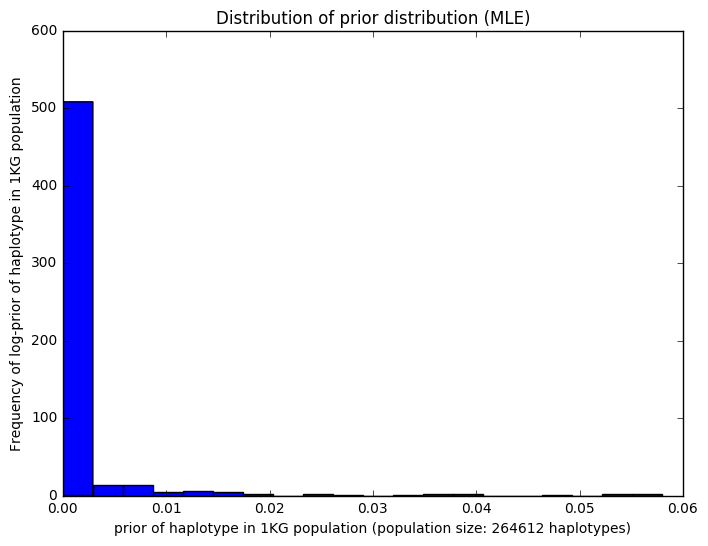

In [121]:
make_hist(np.exp(log_priors),
          title='Distribution of prior distribution (MLE)',
          xlabel = 'prior of haplotype in 1KG population (population size: {} haplotypes)'.format(haps.shape[0]),
          ylabel = 'Frequency of log-prior of haplotype in 1KG population',
          filename = '20170210_Bayesian_online_inference_of_haplotype.prior.png')

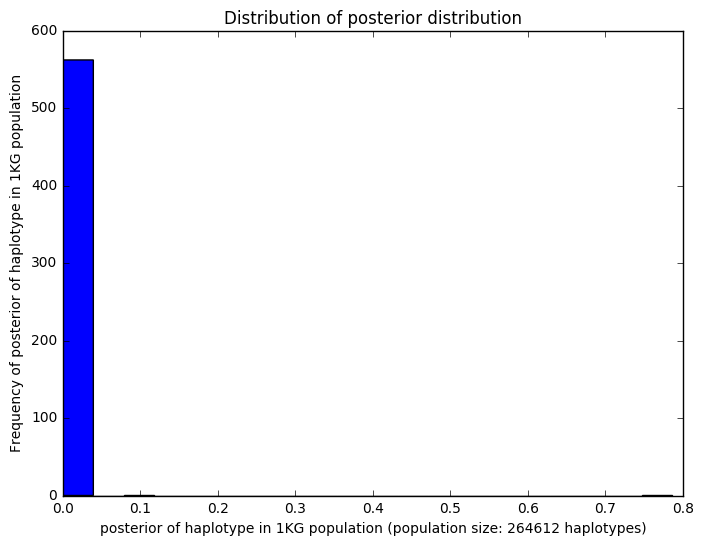

In [122]:
make_hist(np.exp(log_p_h_g_e),
          title='Distribution of posterior distribution',
          xlabel = 'posterior of haplotype in 1KG population (population size: {} haplotypes)'.format(haps.shape[0]),
          ylabel = 'Frequency of posterior of haplotype in 1KG population',
          filename = '20170210_Bayesian_online_inference_of_haplotype.posterior334.png')

In [123]:
print 'observed haplotype is {}'.format(bin(hap_334))

observed haplotype is 0b111111111111111


In [125]:
print 'prior probability is {}'.format(np.exp(log_priors[uniq_id_of_hap[hap_334]]))

prior probability is 0.0364080238236


In [126]:
print 'posterior probability is {}'.format(np.exp(log_p_h_g_e[uniq_id_of_hap[hap_334]]))

posterior probability is 0.786051570702


In [127]:
print 'Haplotype {} means the read has pri allells for all the positions in the following table:'.format(bin(hap_334))

Haplotype 0b111111111111111 means the read has pri allells for all the positions in the following table:


In [128]:
bim334

,chr,id,morgan,bp,pri,sec
18585,20,rs2317021,0,714008,A,G
18687,20,rs6117373,0,717649,C,T
18757,20,rs2144930,0,720916,G,A
18935,20,rs60461885,0,727476,C,T
18967,20,rs6054508,0,728499,A,C
19046,20,rs57596504,0,730893,C,T
19050,20,rs13039346,0,731005,A,G
19089,20,rs6140092,0,732295,A,G
19159,20,rs56210940,0,734617,A,G
19223,20,rs6140099,0,736644,G,A


In [93]:
print 'This matches to our observation: {}, and our inference works successfully'.format(''.join(snp334_filtered[:, 3].tolist()))

This matches to our observation: GTATCTGGGATGATA, and our inference works successfully


- The Platinum Genome vcf file says there is no SNP on 'rs6077095' (6-th column on the following table), but I suspect it is a mistake

In [95]:
print snp334_filtered

[['chr20' '714008' 'a' 'G' 'rs2317021' 'True' '18']
 ['chr20' '717649' 'c' 'T' 'rs6117373' 'True' '16']
 ['chr20' '720916' 'G' 'A' 'rs2144930' 'True' '14']
 ['chr20' '727476' 'c' 'T' 'rs60461885' 'True' '16']
 ['chr20' '728499' 'a' 'C' 'rs6054508' 'True' '16']
 ['chr20' '730893' 'c' 'T' 'rs57596504' 'True' '16']
 ['chr20' '731005' 'a' 'G' 'rs13039346' 'True' '19']
 ['chr20' '732295' 'a' 'G' 'rs6140092' 'True' '19']
 ['chr20' '734617' 'a' 'G' 'rs56210940' 'True' '16']
 ['chr20' '736644' 'g' 'A' 'rs6140099' 'True' '16']
 ['chr20' '743018' 'G' 'T' 'rs6038642' 'True' '18']
 ['chr20' '743124' 'C' 'G' 'rs13039544' 'True' '14']
 ['chr20' '743827' 'g' 'A' 'rs910858' 'True' '16']
 ['chr20' '745181' 'A' 'T' 'rs6077095' 'False' '18']
 ['chr20' '746098' 'G' 'A' 'rs3746808' 'True' '16']]
